# COMP90055 Project

## Google Maps Benchmark Dataset Construction

In [2]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

In [1]:
# ----------------
# Set up API Keys
# ----------------

import os
from dotenv import load_dotenv

load_dotenv()  # load .env file

openai_key = os.getenv("OPENAI_API_KEY")
google_maps_key = os.getenv("GOOGLE_MAPS_API_KEY")

## A list of common Google Maps Places Types

In [53]:
# Common Google Maps places types -- up to 50 places types can be specified

common_placesTypes = [
    "gas_station","parking", "car_dealer", "car_repair","car_wash",
    "library", "school","university",
    "amusement_center","park", "tourist_attraction",
    "atm", "bank",
    "bakery","bar","cafe", "restaurant","police","post_office",
    "hospital","pharmacy","spa",
    "apartment_building", "housing_complex",
    "public_bathroom",
    "hotel",
    "beach",
    "church",
    "barber_shop","beauty_salon","florist",
    "insurance_agency","laundry","lawyer",
    "real_estate_agency","travel_agency","veterinary_care",
    "book_store","clothing_store","convenience_store","grocery_store", "store","supermarket",
    "fitness_center","gym","stadium",
    "airport","bus_station","train_station", "transit_station"
]

In [4]:
len(common_placesTypes)

50

## 1. Location Sampling (Study Region: the Greater Melbourne)

EPSG:7844


,GCC_CODE21,GCC_NAME21,CHG_FLAG21,CHG_LBL21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,1GSYD,Greater Sydney,0,No change,1,New South Wales,AUS,Australia,1.236869e+04,http://linked.data.gov.au/dataset/asgsed3/GCCS...,"MULTIPOLYGON (((151.28159 -33.83318, 151.28151..."
1,1RNSW,Rest of NSW,0,No change,1,New South Wales,AUS,Australia,7.884290e+05,http://linked.data.gov.au/dataset/asgsed3/GCCS...,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
2,19499,No usual address (NSW),0,No change,1,New South Wales,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/GCCS...,None
3,19799,Migratory - Offshore - Shipping (NSW),0,No change,1,New South Wales,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/GCCS...,None
4,2GMEL,Greater Melbourne,0,No change,2,Victoria,AUS,Australia,9.992608e+03,http://linked.data.gov.au/dataset/asgsed3/GCCS...,"MULTIPOLYGON (((144.88829 -38.5026, 144.88825 ..."
5,2RVIC,Rest of Vic.,0,No change,2,Victoria,AUS,Australia,2.175036e+05,http://linked.data.gov.au/dataset/asgsed3/GCCS...,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
6,29499,No usual address (Vic.),0,No change,2,Victoria,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/GCCS...,None
7,29799,Migratory - Offshore - Shipping (Vic.),0,No change,2,Victoria,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/GCCS...,None
8,3GBRI,Greater Brisbane,0,No change,3,Queensland,AUS,Australia,1.584201e+04,http://linked.data.gov.au/dataset/asgsed3/GCCS...,"MULTIPOLYGON (((153.23213 -27.42089, 153.23254..."
9,3RQLD,Rest of Qld,0,No change,3,Queensland,AUS,Australia,1.714329e+06,http://linked.data.gov.au/dataset/asgsed3/GCCS...,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."


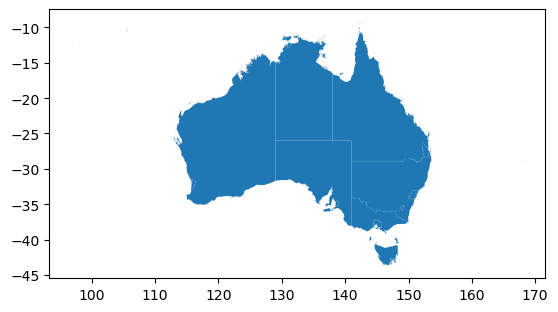

In [66]:
# ===============================================
# 1. Define Centroids
# ===============================================

# Australia Boundary Shape  file
shapefile_path = "../raw/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"

# Read shapefile
ausBound_gdf = gpd.read_file(shapefile_path)

# Inspect
print(ausBound_gdf.crs)            # coordinate reference system
ausBound_gdf.plot()                # quick visualization
ausBound_gdf

In [67]:
# Select only Greater Melbourne region
melbourne_gdf = ausBound_gdf[ausBound_gdf["GCC_NAME21"]=="Greater Melbourne"].to_crs(epsg=3111)  # GDA94 -- State-wise coordinate system

# merge all multi-polygons to a single polygon,or still several polygons
melbourne_geom = melbourne_gdf.geometry.unary_union
print(type(melbourne_geom))

## Still multi-polygon

<class 'shapely.geometry.multipolygon.MultiPolygon'>


/var/folders/hj/vv1_22l15r9b8g8qnmb1pyc40000gn/T/ipykernel_2109/2322970765.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  melbourne_geom = melbourne_gdf.geometry.unary_union


In [68]:
##### ----- 1.A Grid-sample within Melbourne -----#####

# Get Melbourne bounds
minx, miny, maxx, maxy = melbourne_geom.bounds

# Set step (distance between points in km) -- Melbourne width approx: 80km N-S, 60km E-W
step = 10000

# Generate grid
points = [Point(x, y) for x in np.arange(minx, maxx, step) 
                       for y in np.arange(miny, maxy, step)]

# Convert to GeoDataFrame
points_gdf = gpd.GeoDataFrame(geometry=points, crs=melbourne_gdf.crs)  # Melbourne gdf crs: EPSG 7844

# Keep only points inside Melbourne MultiPolygon
grid_pts = points_gdf[points_gdf.within(melbourne_geom)]

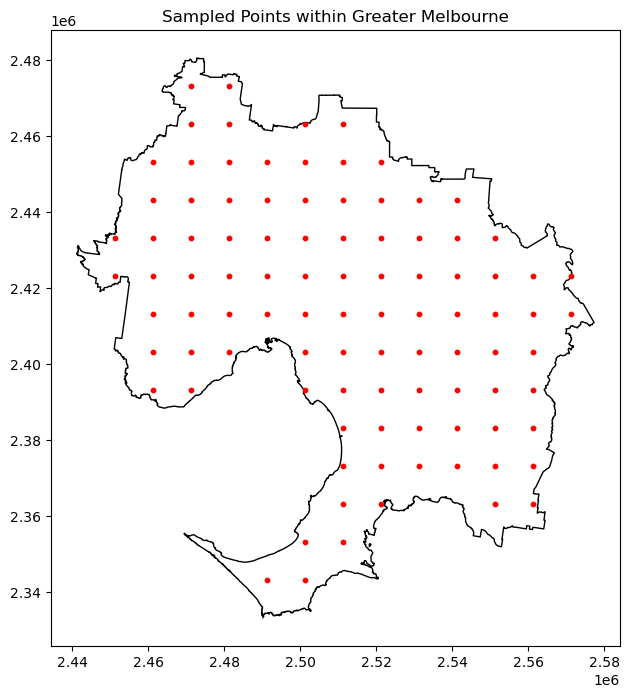

In [69]:
# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 8))
gpd.GeoSeries([melbourne_geom], crs=3111).plot(ax=ax, facecolor="white", edgecolor="black")
grid_pts.plot(ax=ax, color="red", markersize=10)
plt.title("Sampled Points within Greater Melbourne")
plt.show()

EPSG:7844


,state_code_2021,state_name_2021,gccsa_code_2021,gccsa_name_2021,sa4_code_2021,sa4_name_2021,sa3_code_2021,sa3_name_2021,sa2_code_2021,sa2_name_2021,...,births_2023_24,deaths_2023_24,natural_increase_2023_24,internal_arrivals_2023_24,internal_departures_2023_24,net_internal_migration_2023_24,overseas_arrivals_2023_24,overseas_departures_2023_24,net_overseas_migration_2023_24,geometry
0,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,101021007,Braidwood,...,40,29,11,304,240,64,20,7,13,"MULTIPOLYGON (((149.58424 -35.44426, 149.58432..."
1,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,101021008,Karabar,...,121,39,82,763,932,-169,80,28,52,"MULTIPOLYGON (((149.21899 -35.36738, 149.21947..."
2,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,101021009,Queanbeyan,...,183,137,46,1164,1415,-251,245,85,160,"MULTIPOLYGON (((149.21326 -35.34325, 149.20804..."
3,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,101021010,Queanbeyan - East,...,86,22,64,600,711,-111,124,42,82,"MULTIPOLYGON (((149.24034 -35.34781, 149.2396 ..."
4,1,New South Wales,1RNSW,Rest of NSW,101,Capital Region,10102,Queanbeyan,101021012,Queanbeyan West - Jerrabomberra,...,143,33,110,1168,1400,-232,194,66,128,"MULTIPOLYGON (((149.19572 -35.36126, 149.19348..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,8,Australian Capital Territory,8ACTE,Australian Capital Territory,801,Australian Capital Territory,80111,Uriarra - Namadgi,801111141,Namadgi,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((148.80407 -35.37619, 148.80459..."
2450,9,Other Territories,9OTER,Other Territories,901,Other Territories,90101,Christmas Island,901011001,Christmas Island,...,9,6,3,0,0,0,44,9,35,"MULTIPOLYGON (((105.67393 -10.41566, 105.67382..."
2451,9,Other Territories,9OTER,Other Territories,901,Other Territories,90102,Cocos (Keeling) Islands,901021002,Cocos (Keeling) Islands,...,4,11,-7,0,0,0,6,3,3,"MULTIPOLYGON (((96.91512 -12.14044, 96.91508 -..."
2452,9,Other Territories,9OTER,Other Territories,901,Other Territories,90103,Jervis Bay,901031003,Jervis Bay,...,3,3,0,0,0,0,0,0,0,"MULTIPOLYGON (((150.69567 -35.18295, 150.69513..."


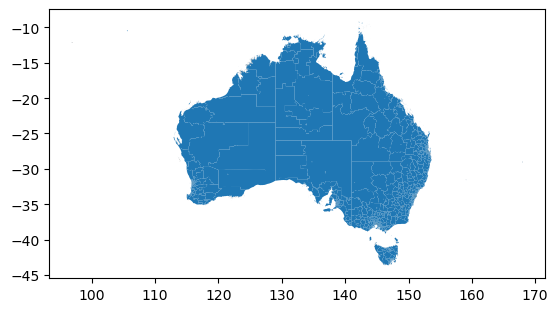

In [70]:
##### ----- 1.B Stratified Sampling -----#####
### Sampling by population density (at SA3 level) ###

# Population estimate by SA2 and above (2024)
shapefile_path = "../raw/32180_ERP_2024_SA2_GDA2020/32180_ERP_2024_SA2_GDA2020.gpkg"

# Read shapefile
ausPop_gdf = gpd.read_file(shapefile_path)

# Inspect
print(ausPop_gdf.crs) 
#print(vic_pop_gdf.columns)
ausPop_gdf.plot()            
ausPop_gdf

In [71]:
# Filter Victoria data
vicPop_gdf = ausPop_gdf[ausPop_gdf["state_name_2021"] == "Victoria"]

### Filter Greater Melbourne data (by geographical overlap) ###
# convert crs of both gdf to ESPG 3111
vicPop_gdf = vicPop_gdf.to_crs(melbourne_gdf.crs)
melPop_gdf = gpd.sjoin(vicPop_gdf, melbourne_gdf, how="inner", predicate='within')
melPop_gdf = melPop_gdf[["state_name_2021", "gccsa_name_2021", "sa3_name_2021", "erp_2024", "pop_density_2024_people_per_km2", "area_km2", "geometry"]]

# merge by SA3 level
melPop_gdf = melPop_gdf.dissolve(by="sa3_name_2021")

# Sort by population density descending
melPop_gdf = melPop_gdf.sort_values(by="pop_density_2024_people_per_km2", ascending=False)

# Check result
melPop_gdf #.head(40)

,geometry,state_name_2021,gccsa_name_2021,erp_2024,pop_density_2024_people_per_km2,area_km2
sa3_name_2021,,,,,,
Melbourne City,"POLYGON ((2496219.611 2408069.533, 2496168.282...",Victoria,Greater Melbourne,23954,13170.9500,1.8187
Port Phillip,"MULTIPOLYGON (((2499455.124 2404787.373, 24995...",Victoria,Greater Melbourne,17332,7181.2720,2.4135
Brunswick - Coburg,"POLYGON ((2497189.649 2413526.195, 2497149.589...",Victoria,Greater Melbourne,14438,6658.9800,2.1682
Yarra,"POLYGON ((2501360.062 2408932.7, 2501360.329 2...",Victoria,Greater Melbourne,10294,5914.3920,1.7405
Stonnington - West,"POLYGON ((2502639.098 2405446.539, 2502632.589...",Victoria,Greater Melbourne,9997,4578.4290,2.1835
Glen Eira,"POLYGON ((2507232.369 2397359.341, 2507218.865...",Victoria,Greater Melbourne,26825,4309.7910,6.2242
Essendon,"POLYGON ((2494603.13 2413345.334, 2494623.446 ...",Victoria,Greater Melbourne,16154,4211.0480,3.8361
Stonnington - East,"POLYGON ((2505593.967 2403770.257, 2505592.376...",Victoria,Greater Melbourne,21680,3522.2250,6.1552
Darebin - South,"POLYGON ((2502748.622 2414918.979, 2502751.155...",Victoria,Greater Melbourne,9688,3357.7100,2.8853


In [72]:
# Choose the top 10 population dense SA3 regions
top30_gdf = melPop_gdf.nlargest(30, "pop_density_2024_people_per_km2")

## Sample points by population density
top30_gdf["weight"] = top30_gdf["pop_density_2024_people_per_km2"]
top30_gdf["weight"] /= top30_gdf["weight"].sum()  # normalise

N = 120
top30_gdf["num_points"] = (N*top30_gdf["weight"]).round().astype(int)

## Sample within each polygon

def sample_points_in_polygon(polygon, n):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < n:
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        p = Point(x, y)
        if polygon.contains(p):  # check if within the polygon
            points.append(p)
    return points

# iterate through the rows in top25_gdf
stratified_points = []
for _, row in top30_gdf.iterrows():
    n = row["num_points"]
    polygon = row["geometry"]
    stratified_points.extend(sample_points_in_polygon(polygon, n))  
    
# Integarate stratified sampling points into all points
stratified_pts = gpd.GeoDataFrame(geometry=stratified_points, crs=grid_pts.crs)
centroids = pd.concat([grid_pts, stratified_pts], ignore_index=True)

# remove duplication
centroids = centroids.drop_duplicates(subset="geometry")

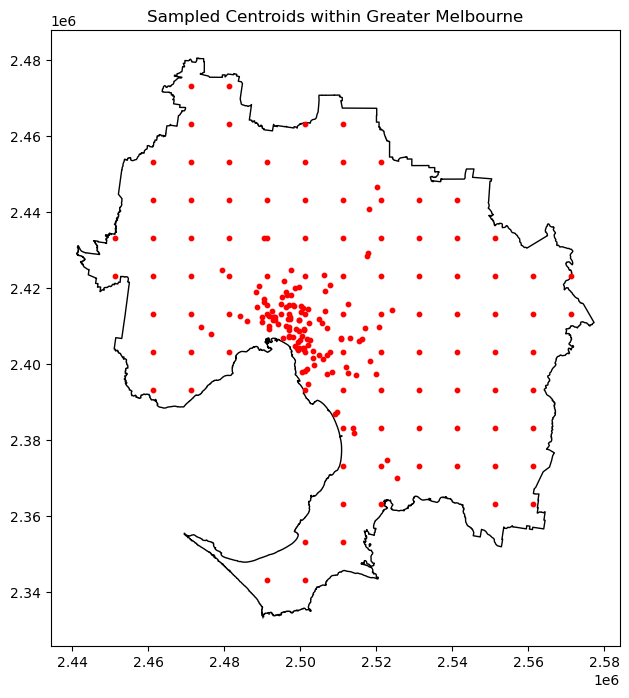

In [73]:
# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 8))
gpd.GeoSeries([melbourne_geom], crs=3111).plot(ax=ax, facecolor="white", edgecolor="black")
centroids.plot(ax=ax, color="red", markersize=10)
plt.title("Sampled Centroids within Greater Melbourne")
plt.show()

# --- Save Centroids ---#
centroids.to_file("../curated/centroids.shp")

## 2. Nearby search by Google Maps API

In [120]:
import numpy as np
from scipy.spatial import cKDTree
import requests
import time
import json

In [121]:
# Determine sampling radius for each centroid

cen_gdf = gpd.read_file("../curated/centroids.shp")

# Extract coordinates
coords = np.array(list(zip(cen_gdf.geometry.x, cen_gdf.geometry.y)))
print(coords.shape)

# Build KDTree
tree = cKDTree(coords)

# Query nearest neighbor (k=2 because the closest point to a point is itself)
distances, indices = tree.query(coords, k=2)

# Take the second column (first column is distance to self = 0)
cen_gdf["nearest_dist_km"] = (distances[:, 1] / 1000).round(0)

print("The distance between points range from {}km to {}km.".format(min(cen_gdf["nearest_dist_km"]), max(cen_gdf["nearest_dist_km"])))
cen_gdf

(214, 2)
The distance between points range from 0.0km to 10.0km.


,FID,geometry,nearest_dist_km
0,0,POINT (2451190.245 2423181.163),10.0
1,1,POINT (2451190.245 2433181.163),10.0
2,2,POINT (2461190.245 2393181.163),10.0
3,3,POINT (2461190.245 2403181.163),10.0
4,4,POINT (2461190.245 2413181.163),10.0
...,...,...,...
209,209,POINT (2499592.724 2420329.613),1.0
210,210,POINT (2520760.312 2409741.485),3.0
211,211,POINT (2524180.712 2414163.848),3.0
212,212,POINT (2517682.975 2428406.666),1.0


In [122]:
# Convert crs into EPSG: 7844, so that latitudes and longitudes are in Google Maps API argument range

cen_gdf = cen_gdf.to_crs(7844)
cen_gdf.crs

<Geographic 2D CRS: EPSG:7844>
Name: GDA2020
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia including Lord Howe Island, Macquarie Island, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore.
- bounds: (93.41, -60.55, 173.34, -8.47)
Datum: Geocentric Datum of Australia 2020
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [125]:
# API_KEY = google_maps_key
# responses = []
# results = []

# for _, row in cen_gdf.iterrows():
    
#     ### Forming Request ###
#     lng, lat = row["geometry"].x, row["geometry"].y  # x-coordinate: longitude, y-coordinate: latitude
#     radius = row["nearest_dist_km"] * 1000  # convert km to m
    
#     url = "https://places.googleapis.com/v1/places:searchNearby"

#     headers = {
#         "Content-Type": "application/json",
#         "X-Goog-Api-Key": API_KEY, 
#         "X-Goog-FieldMask": "places.displayName,places.formattedAddress,places.location,places.types" # space is not allowed!!!
#     }

#     body = {
#         "includedTypes": common_placesTypes,
#         "maxResultCount": 20,
#         "locationRestriction": {
#             "circle": {
#                 "center": {
#                     "latitude": lat,
#                     "longitude": lng
#                 },
#                 "radius": radius
#             }
#         }
#     }
    
#     ### Post Request ###
#     response = requests.post(url, headers=headers, json=body)
#     responses.append(response)
    
#     ### Check and Parse Response ###
#     if response.status_code == 200:
#         data = response.json() # parse into python dict
        
#         for place in data.get('places', []):
#             results.append(place)
            
#     time.sleep(0.5)

# print(f"Total requests: {len(cen_gdf)}")
# print(f"Total success requests: {len(responses)}")
# print(f"Total places fetched: {len(results)}")

Total requests: 214
Total success requests: 214
Total places fetched: 3856


In [149]:
# see how many distinctive locations

address_list = [location["formattedAddress"] for location in results]
print(f"Total locations: {len(address_list)}")
print(f"Distinct locations: {len(set(address_list))}")

Total locations: 3856
Distinct locations: 2720


In [150]:
# remove duplicated locations

seen_addresses = set()
no_repeat_locations = []

for item in results:
    if item['formattedAddress'] not in seen_addresses:
        no_repeat_locations.append(item)
        seen_addresses.add(item['formattedAddress'])
        
print(len(no_repeat_locations))

2720


In [151]:
no_repeat_locations[0:5]

[{'types': ['state_park',
   'tourist_attraction',
   'park',
   'point_of_interest',
   'establishment'],
  'formattedAddress': '204 Myers Rd, Pentland Hills VIC 3341, Australia',
  'location': {'latitude': -37.663111799999996,
   'longitude': 144.36317540000002},
  'displayName': {'text': 'Werribee Gorge State Park (Parks Victoria)',
   'languageCode': 'en'}},
 {'types': ['farm',
   'food_store',
   'store',
   'food',
   'point_of_interest',
   'establishment'],
  'formattedAddress': '638 Bacchus Marsh Rd, Bacchus Marsh VIC 3340, Australia',
  'location': {'latitude': -37.688320000000004,
   'longitude': 144.47671699999998},
  'displayName': {'text': 'Naturipe Fruits - Bacchus Marsh Cherry, Stonefruit and Apple Farm',
   'languageCode': 'en'}},
 {'types': ['school', 'point_of_interest', 'establishment'],
  'formattedAddress': '37 S Maddingley Rd, Maddingley VIC 3340, Australia',
  'location': {'latitude': -37.6893238, 'longitude': 144.4316258},
  'displayName': {'text': 'Bacchus Mar

In [152]:
### save test retrieved locations ###
places = no_repeat_locations

# Writing to a JSON file with indentation
with open("../curated/location_sampling_output.json", "w") as f:
    json.dump(places, f, indent=4)

## 3. Question Prototypes construction

In [89]:
import random
import json

from collections import defaultdict

In [90]:
# ===================================
#  3.1 Construct Question Templates
# ===================================

# We introduce three typical types of questions:
# Type 1: simplest form of our focusing question 
# Type 2: simple form + buffer range along the route
# Type 3: simple form + a waypoint

question_templates = [
    "Find me a {place_type} along the way from {location_A} to {location_B}.",
    "Find me a {place_type} along the way from {location_A} to {location_B}, within {buffer_range}km of the route.",
    "Find me a {place_type} along the way from {location_A} to {location_B}, passing through {location_C}."
]

# weights of different question types
question_weights = [0.5, 0.25, 0.25]

In [91]:
#####----- POI Preparation -----#####

common_POIs = [
    "gas_station",
    "parking",
    "school",
    "police",
    "amusement_center","park", "tourist_attraction",
    "atm",
    "bank",
    "bakery",
    "bar",
    "cafe",
    "restaurant",
    "hospital",
    "hotel",
    "beach",
    "convenience_store",
    "grocery_store",
    "supermarket",
    "fitness_center",
    "gym",
    "bus_station",
    "train_station", "transit_station"
]

# POI-code - to - natural-language POI type
placesType_dict = common_place_type_map = {
    "gas_station": "gas station",
    "parking": "parking area",
    "car_dealer": "car dealer",
    "car_repair": "car repair shop",
    "car_wash": "car wash",
    
    "library": "library",
    "school": "school",
    "university": "university",
    
    "amusement_center": "amusement center",
    "park": "park",
    "tourist_attraction": "tourist attraction",
    
    "atm": "atm",
    "bank": "bank",
    
    "bakery": "bakery",
    "bar": "bar",
    "cafe": "cafe",
    "restaurant": "restaurant",
    "police": "police station",
    "post_office": "post office",
    
    "hospital": "hospital",
    "pharmacy": "pharmacy",
    "spa": "spa",
    
    "apartment_building": "apartment building",
    "housing_complex": "house",
    
    "public_bathroom": "public bathroom",
    
    "hotel": "hotel",
    
    "beach": "beach",
    
    "church": "church",
    
    "barber_shop": "barber shop",
    "beauty_salon": "beauty salon",
    "florist": "florist",
    
    "insurance_agency": "insurance agency",
    "laundry": "laundry",
    "lawyer": "lawyer",
    
    "real_estate_agency": "real estate agency",
    "travel_agency": "travel agency",
    "veterinary_care": "veterinary care",
    
    "book_store": "book store",
    "clothing_store": "clothing store",
    "convenience_store": "convenience store",
    "grocery_store": "grocery store",
    "store": "store",
    "supermarket": "supermarket",
    
    "fitness_center": "fitness center",
    "gym": "gym",
    "stadium": "stadium",
    
    "airport": "airport",
    "bus_station": "bus station",
    "train_station": "train station",
    "transit_station": "transit station"
}

In [92]:
#####----- Location Preparation -----#####

# Read location file
with open("../curated/location_sampling_output.json", 'r') as f:
    places = json.load(f)

    
# Get the list of duplicate location names
seen_loc_name = set()
duplicate_loc_name = set()

for place in places:
    if place["displayName"]['text'] not in seen_loc_name:
        seen_loc_name.add(place["displayName"]['text'])
    else:
        duplicate_loc_name.add(place["displayName"]['text'])
        
'''
Build a location dictionary of format:

key -- displayName of locations 
       (for common names (in duplicate_loc_name, e.g., 7_Eleven, ALDI...), add address to location name 
       so that the questions can more interpretable and natural)
       
value -- a dictionary of fields: location (lat, lng), loc_address
'''
location_names = defaultdict(dict)

for place in places:
    name = place["displayName"]['text']
    
    if name not in duplicate_loc_name:
        location_names[name]["location"] = place["location"]
        location_names[name]["formattedAddress"] = place["formattedAddress"]
    
    else:
        name = name + ' at ' + place["formattedAddress"]  # e.g., 7-Eleven at 28 Main St, Bacchus Marsh VIC 3340, Australia
        location_names[name]["location"] = place["location"]
        location_names[name]["formattedAddress"] = place["formattedAddress"]
        
print(f"There are {len(location_names)} final locations been extracted.")

There are 2720 final locations been extracted.


In [93]:
# ========================
# 3.2 Question Generation 
# ========================

'''
Generate a question through sampling locations, based on question template
    Input: 
        template: the question template
        placeType_sample_list: a list of POI types for sampling
        loc_sample_dict: a dictionary of locations for sampling
    Output:
        the generated question
        
    Tips: 
        1. All locations should not duplicate with each other
        2. "from location_A to location_B" == " from location_B to location_A"
'''
def generate_question(template, placeType_sample_list, loc_sample_dict, used_pairs=set()):
    
    if 'within' in template:  # q2
        place_type = random.choices(placeType_sample_list, k=1)
        place_type_nl = placesType_dict[place_type[0]]
        # we need to sample non-duplicate location pairs, use do-while loop
        locs = []
        i = 0
        while (True):
            locs = random.choices(list(loc_sample_dict), k=2)
            pair = tuple(sorted(locs))
            i += 1
            if (locs[0] == locs[1]) or (pair in used_pairs) :
                print(locs)
                print("----resample----")
                continue
            else:
                used_pairs.add(pair)
                break
        buffer_range = random.randint(5, 10)  # apply a buffer range between 5 to 10 km
        
        q = template.format(
            place_type=place_type_nl,
            location_A=locs[0], 
            location_B=locs[1],
            buffer_range=buffer_range  # check if the two locations are duplciated
        )
        
        res_dict = {"question": q, "POI_type": place_type[0], 
                    "location_A": locs[0], 
                    "location_A_coord": loc_sample_dict[locs[0]]['location'],
                    "location_A_addr": loc_sample_dict[locs[0]]['formattedAddress'],
                    "location_B": locs[1],
                    "location_B_coord": loc_sample_dict[locs[1]]['location'],
                    "location_B_addr": loc_sample_dict[locs[1]]['formattedAddress'],
                    "buffer_range": buffer_range}
        
    elif 'passing' in template:  # q3
        place_type = random.choices(placeType_sample_list, k=1)
        place_type_nl = placesType_dict[place_type[0]]
        # we need to sample non-duplicate location pairs, use do-while loop
        locs = []
        i = 0
        while (True):
            locs = random.choices(list(loc_sample_dict), k=3)
            pair = tuple(sorted([locs[0], locs[1]]))
            i += 1
            if (len(set(locs)) < len(locs)) or (pair in used_pairs):  # no duplications
                print(locs)
                print("----resample----")
                continue
            else:
                used_pairs.add(pair)
                break
        
        q = template.format(
            place_type=place_type_nl,
            location_A=locs[0], #["name"],
            location_B=locs[1], #["name"],
            location_C=locs[2]  #["name"]
        )
        
        res_dict = {"question": q, "POI_type": place_type[0], 
                    "location_A": locs[0], 
                    "location_A_coord": loc_sample_dict[locs[0]]['location'],
                    "location_A_addr": loc_sample_dict[locs[0]]['formattedAddress'],
                    "location_B": locs[1],
                    "location_B_coord": loc_sample_dict[locs[1]]['location'],
                    "location_B_addr": loc_sample_dict[locs[1]]['formattedAddress'], 
                    "location_C": locs[2],
                    "location_C_coord": loc_sample_dict[locs[2]]['location'],
                    "location_C_addr": loc_sample_dict[locs[2]]['formattedAddress']
                   }
        
    else:  # q1
        place_type = random.choices(placeType_sample_list, k=1)
        place_type_nl = placesType_dict[place_type[0]]
        # we need to sample non-duplicate location pairs, use do-while loop
        locs = []
        i = 0
        while (True):
            locs = random.choices(list(loc_sample_dict), k=2)
            pair = tuple(sorted(locs))
            i += 1
            if (locs[0] == locs[1]) or (pair in used_pairs):
                print(locs)
                print("----resample----")
                continue
            else:
                used_pairs.add(pair)
                break
        
        q = template.format(
            place_type=place_type_nl,
            location_A=locs[0], #["name"],
            location_B=locs[1]  #["name"]
        )
        
        res_dict = {"question": q, "POI_type": place_type[0], 
                    "location_A": locs[0], 
                    "location_A_coord": loc_sample_dict[locs[0]]['location'],
                    "location_A_addr": loc_sample_dict[locs[0]]['formattedAddress'],
                    "location_B": locs[1],
                    "location_B_coord": loc_sample_dict[locs[1]]['location'],
                    "location_B_addr": loc_sample_dict[locs[1]]['formattedAddress']}
        
    return res_dict

In [94]:
# Generate roughly 1800 questions, based on weights

N = 1800
# N = 10
weights = [0.5, 0.25, 0.25]
counts = [int(N * w) for w in weights]

# build list with exact counts
questions = (
    [question_templates[0]] * counts[0] +
    [question_templates[1]] * counts[1] +
    [question_templates[2]] * counts[2]
)

random.shuffle(questions)  # randomize order

for i in range(len(questions)):
    template = questions[i]
    q = generate_question(template, common_POIs, location_names)
    questions[i] = q

['Bladeworx', 'Bladeworx']
----resample----
['Industrial Strength & Fitness (ISF) Reservoir', 'Southside Racing Cranbourne', 'Industrial Strength & Fitness (ISF) Reservoir']
----resample----


In [95]:
for q in questions[0:5]:
    print(q)

{'question': "Find me a school along the way from Gilwell Park | Scout Adventure Centre to Cravin’ Crepes Edgewater, passing through KRABBY'S CRAB BOIL.", 'POI_type': 'school', 'location_A': 'Gilwell Park | Scout Adventure Centre', 'location_A_coord': {'latitude': -37.918240499999996, 'longitude': 145.57184569999998}, 'location_A_addr': '2555 Gembrook-Launching Pl Rd, Gembrook VIC 3783, Australia', 'location_B': 'Cravin’ Crepes Edgewater', 'location_B_coord': {'latitude': -37.7863496, 'longitude': 144.8999864}, 'location_B_addr': '33 Cumberland Dr, Maribyrnong VIC 3032, Australia', 'location_C': "KRABBY'S CRAB BOIL", 'location_C_coord': {'latitude': -37.8123815, 'longitude': 144.9378477}, 'location_C_addr': 'District Docklands CCF01, LEVEL 1/3-6 Star Circus, Docklands VIC 3008, Australia'}
{'question': 'Find me a atm along the way from CERES Organic Cafe to Melbourne TMJ & Facial Pain Centre.', 'POI_type': 'atm', 'location_A': 'CERES Organic Cafe', 'location_A_coord': {'latitude': -37.

In [96]:
### Save questions ###
# Writing to a JSON file with indentation
with open("../curated/question_prototypes.json", "w") as f:
    json.dump(questions, f, indent=4)

## 4. Question Prototype Distance Screening

This section remove question outliers that involves too short or too long distance between origin and destination, considering the background of having "DRIVE" mode.

In [9]:
import time
from itertools import islice
import requests
import json

import polyline
from shapely.geometry import LineString
from pyproj import Transformer
import matplotlib.pyplot as plt
import numpy as np

In [135]:
# Read question prototypes (1800 in total)

with open("../curated/question_prototypes.json", "r") as f:
    prototypes = json.load(f)

In [136]:
'''
This function parses the route object responsed by Google Maps API and return a list of encoded polylines 
    Input:
        route: a json object
        origin: origin of the entire route
        dest: destination of the entire route
    Output:
        polylines: a list of 1 or 2 encoded polylines
'''
def parse_route(route, origin, dest):
    
    polylines = []
    
    # if only one leg within a route
    if 'legs' not in route:
        polylines.append({'encodedPolyline': route['polyline']['encodedPolyline'],
                          'origin': origin,
                          'destination': dest,
                          'distanceMeters': route['distanceMeters'],
                          'duration': route['duration']})
    
    # if two legs within a route
    else:
        legs = route['legs']
        for leg in legs:
            polylines.append({'encodedPolyline': leg['polyline']['encodedPolyline'],
                          'origin': leg['startLocation']['latLng'],
                          'destination': leg['endLocation']['latLng'],
                          'distanceMeters': leg['distanceMeters'],
                          'duration': leg['duration']})
        
            
    return polylines

In [137]:
'''
This function compute routes (i.e., a single or a list of polylines) 

Inputs: 
    API_KEY:
    origin:
    dest:
    travel_mode:
    waypoint (optional):  
    
Output: 
    list(): encoded_polylines -- a list (1 or 2) encoded polylines
'''

def compute_route(API_KEY, origin, dest, travel_mode, waypoint=None):
    
    result = []
    
    ### Forming Request ###
    url = "https://routes.googleapis.com/directions/v2:computeRoutes"
    
    # if the question does not contain waypoint
    if waypoint is None:
        headers = {
            "Content-Type": "application/json",
            "X-Goog-Api-Key": API_KEY, 
            "X-Goog-FieldMask": "routes.duration,routes.polyline.encodedPolyline,routes.distanceMeters"
        } 

        body = {
                "origin":{
                "location":{
                  "latLng":{
                    "latitude": origin['latitude'],
                    "longitude": origin['longitude']
                  }
                }
              },
              "destination":{
                "location":{
                  "latLng":{
                    "latitude": dest['latitude'],
                    "longitude": dest['longitude']
                  }
                }
              },
              "travelMode": "DRIVE",  # we focus on driving queries, if distance too small, remove from the list
              "languageCode": "en-US",
              "units": "METRIC"
        }
    
    # if the question contains a waypoint
    if waypoint is not None:
        headers = {
            "Content-Type": "application/json",
            "X-Goog-Api-Key": API_KEY, 
            "X-Goog-FieldMask": "routes.duration,routes.distanceMeters,routes.legs" # specify the route legs to return all 2 legs
        } 

        body = {
                "origin":{
                "location":{
                  "latLng":{
                    "latitude": origin['latitude'],
                    "longitude": origin['longitude']
                  }
                }
              },
              "destination":{
                "location":{
                  "latLng":{
                    "latitude": dest['latitude'],
                    "longitude": dest['longitude']
                  }
                }
              },
              "intermediates": [
              {
                "location":{
                  "latLng":{
                    "latitude": waypoint['latitude'],
                    "longitude": waypoint['longitude']
                  }
                }
              }
            ],
              "travelMode": "DRIVE",  # we focus on driving queries, if distance too small, remove from ths lis
              "languageCode": "en-US",
              "units": "METRIC"
        }
    
    
    ### Post Request ###
    response = requests.post(url, headers=headers, json=body)
    
    ### Check and Parse Response ###
    if response.status_code == 200:
        data = response.json() # parse into python dict
        
        route = data.get('routes', [])[0]  #since there is no alternative routes, so we take the only route

    # parse Google Maps response
    poly_list = parse_route(route, origin, dest)
    
    time.sleep(0.5)
    
    return poly_list

In [138]:
# ==========================================
# 4.1 Compute Route for Question Prototypes
# ==========================================
API_KEY = google_maps_key

prototypes_withRoute = []
for p in prototypes:
    
    # type 1 & 2 question (no waypoint)
    if 'passing' not in p['question']:
        poly_list = compute_route(API_KEY, p['location_A_coord'], p['location_B_coord'], 'DRIVE')
        p['poly_list'] = poly_list
        prototypes_withRoute.append(p)
    
    # type 3 question (1 waypoint)
    else:
        poly_list = compute_route(API_KEY, p['location_A_coord'], p['location_B_coord'], 'DRIVE', waypoint=p['location_C_coord'])
        p['poly_list'] = poly_list     
        prototypes_withRoute.append(p)

In [139]:
prototypes_withRoute[0:3]

[{'question': "Find me a school along the way from Gilwell Park | Scout Adventure Centre to Cravin’ Crepes Edgewater, passing through KRABBY'S CRAB BOIL.",
  'POI_type': 'school',
  'location_A': 'Gilwell Park | Scout Adventure Centre',
  'location_A_coord': {'latitude': -37.918240499999996,
   'longitude': 145.57184569999998},
  'location_A_addr': '2555 Gembrook-Launching Pl Rd, Gembrook VIC 3783, Australia',
  'location_B': 'Cravin’ Crepes Edgewater',
  'location_B_coord': {'latitude': -37.7863496, 'longitude': 144.8999864},
  'location_B_addr': '33 Cumberland Dr, Maribyrnong VIC 3032, Australia',
  'location_C': "KRABBY'S CRAB BOIL",
  'location_C_coord': {'latitude': -37.8123815, 'longitude': 144.9378477},
  'location_C_addr': 'District Docklands CCF01, LEVEL 1/3-6 Star Circus, Docklands VIC 3008, Australia',
  'poly_list': [{'encodedPolyline': '`~lfFq}nwZZk@Za@f@h@XPr@PhBA\\NXb@Lf@Fp@YbJShDe@rFAdABd@PzA@j@M`CKxAA`CJf@JRVZ`AbAh@t@\\n@X~@PlALvCF~AF^Vj@RXd@X^L^@h@KjC}@xAa@bAOb@?\\Jj@

In [142]:
### Save prototypes with routes ###

with open("../curated/question_prototypes_withRoute.json", "w") as f:
    json.dump(prototypes_withRoute, f, indent=4)

### Do not run code above

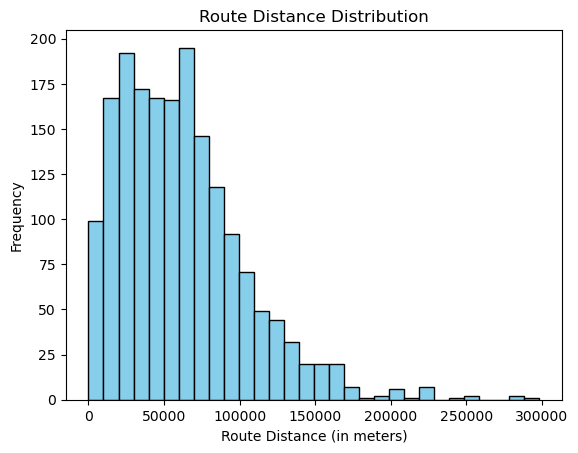

Total number of question prototype: 1800
Route distances range from 28m to 298328m.


In [12]:
# ================
# Outlier Removal
# ================

### visualise distribution of driving distance ###

# Read questions with route
with open("../curated/question_prototypes_withRoute.json", "r") as f:
    proto_withRoute = json.load(f)

# Compute driving distance (in meters)
dist_list = []
for p in proto_withRoute:
    poly_list = p['poly_list']
    route_dist = 0
    
    for poly in poly_list:
        route_dist += poly['distanceMeters']
    
    dist_list.append(route_dist)
    
# Plot ditance distribution
plt.hist(dist_list, bins=30, color='skyblue', edgecolor='black')
plt.title('Route Distance Distribution')
plt.xlabel('Route Distance (in meters)')
plt.ylabel('Frequency')
plt.show()

print(f"Total number of question prototype: {len(dist_list)}")
print(f"Route distances range from {min(dist_list)}m to {max(dist_list)}m.")

In [13]:
### Remove outlier based on interqurtile_range & Drive-mode ###

# Convert to numpy array
dist_arr = np.array(dist_list)

# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(dist_arr, 25)
Q3 = np.percentile(dist_arr, 75)
IQR = Q3 - Q1

# Drive-mode distance restriction (1-60km)
domain_lb = 1000     # m
domain_ub = 60000    # m

# Define bounds for normal data
lower_bound = max(Q1 - 1.5 * IQR, domain_lb)
upper_bound = min(Q1 + 1.5 * IQR, domain_ub)

# Filter out the outliers
filtered_prototypes = []
for i in range(len(dist_arr)):
    if (dist_arr[i] >= lower_bound) & (dist_arr[i] <= upper_bound):
        filtered_prototypes.append(proto_withRoute[i])

filtered_dist = dist_arr[(dist_arr >= lower_bound) & (dist_arr <= upper_bound)]

print(f"Total number of eligible question prototype: {len(filtered_prototypes)}")
print(f"Route distances range from {min(filtered_dist)}m to {max(filtered_dist)}m.")

Total number of eligible question prototype: 965
Route distances range from 1026m to 59914m.


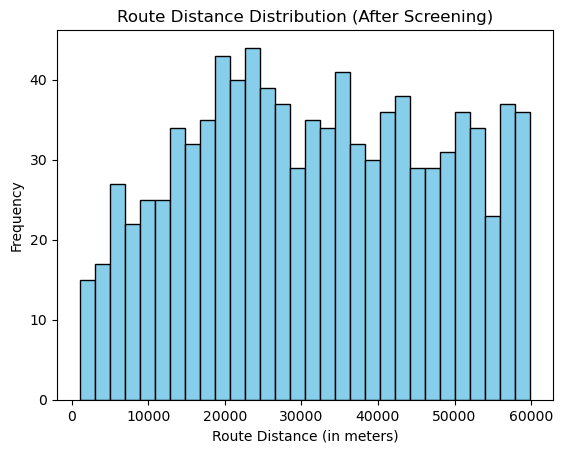

In [14]:
# Plot ditance distribution;
plt.hist(filtered_dist, bins=30, color='skyblue', edgecolor='black')
plt.title('Route Distance Distribution (After Screening)')
plt.xlabel('Route Distance (in meters)')
plt.ylabel('Frequency')
plt.show()

In [15]:
### Save filtered question prototypes

with open('../curated/filtered_prototypes.json', 'w') as f:
    json.dump(filtered_prototypes, f, indent=4)

## 5. Ground-truth Candidates Sampling

**Note** the difference in format for representing points

    points: {lon, lat}
    coord: {lat,  lon}

In [1]:
# ! pip install polyline

In [2]:
from itertools import islice
import requests
import json
import time

import polyline
from shapely.geometry import LineString
from pyproj import Transformer
import matplotlib.pyplot as plt
import numpy as np

### 5.1 Route Point Sampling

In [3]:
def sample_points_from_polylines(encoded_polylines, n_points=2):
    """
    Sample a fixed number of points evenly along each encoded polyline.

    inputs:
        encoded_polylines : list[str]
            A list of encoded polylines (Google format).
        n_points : int
            Number of points to sample along each polyline.

    outputs:
        list[tuple[float, float]]
            A flat list of sampled points as (lat, lon) tuples.
    """
    sampled_points = []

    # Initialize transformer (coordinate conversion)
    transformer = Transformer.from_crs("epsg:7844", "epsg:3111", always_xy=True)  # degree --> meters

    for encoded in encoded_polylines:
        # Decode polyline to list of (lat, lon) coordinates
        coords = polyline.decode(encoded)
        
        # Project coordinates from 7844 to 3111
        line_coords_proj = [transformer.transform(lon, lat) for lat, lon in coords]
        line_proj = LineString(line_coords_proj)

        # Compute distances along line where points will be sampled
        distances = np.linspace(0, line_proj.length, n_points + 2)[1:-1]  # we exclude origin and dest here

        # Interpolate points along the projected line
        sampled_points_proj = [line_proj.interpolate(d) for d in distances]

        # Transform points back to lat/lon
        sampled_points += [transformer.transform(p.x, p.y, direction="INVERSE") for p in sampled_points_proj]

    return sampled_points


[(145.47307983128513, -38.20755143501795), (145.31523779392583, -38.197533160069845), (145.18298566635886, -38.06298651373049), (145.1343452113947, -37.89334894417901)]


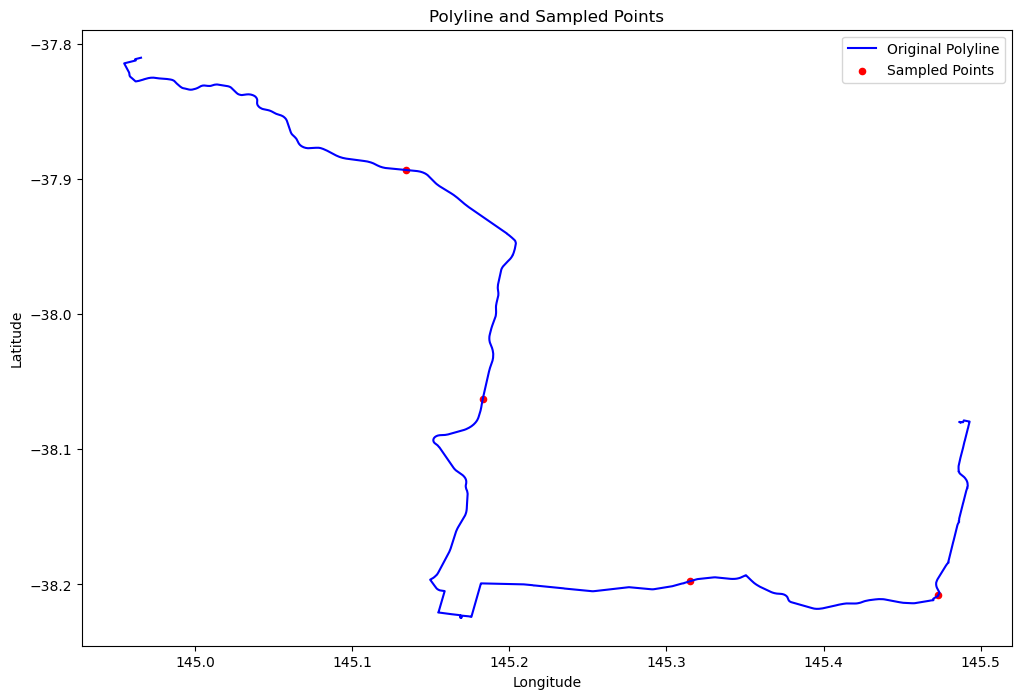

In [4]:
# Route Point Sampling Example
encoded_polylines = [
    'rolgFon~vZIAGF_@rDc@GVeBNaB?q@A}ARwBCOSIoCg@mAYYOd@qC|AyKb@}D~JxAnJjAxCThAXhBXtANlDd@vLbBj@BjDh@~ARfEd@nIjAzANlHlAhHv@vAHlEl@hCXtB\\~Cb@xAXjAN`Dh@bPpBrMfBhVtCtCb@bCXtBN`ABjKB`DUr@Bl@HxA\\VCRINOR]LWTSXCNBXGhAOTGlAu@f@c@fG}G~DcEvC{B~BsAfD_BhBo@hBg@bB[xCc@tBC`EUdBAhALfBv@PDj@ATIFMXMZ?XNZHpAr@zDp@vAZhLxAr^`F~El@pB\\hXrDzGbAlCXdIlA|KzAxIz@pD@|ARjAd@RB\\Ah@[LSXK^FJJZLRNjCtAbGvAr[|DxOvBzFr@bHdApFj@vG`A`s@bJv[lEzAL^?xALr@Pb@PTBr@AP[^IXBPJN`@@JNFf@h@rA|@nFrCf[dN|UnKRBtDrApD|AjDhArEhAlBXRD`BFlC@jBEzBQ~Cc@`Du@hFoBjHwC`@Ox@Od@Gf@?j@@hAPbA^b@V\\TLHdA~@LFf@BRSRGTBVNNTBPpAjBl@dApClFJDT`@b@l@hAdAXNZD\\EJGNYTMVAVHPTJZ?`@ETBtBLfAt@`F~Gxk@t@dHNzBHfEE~Ek@tYQzD_@xEu@fG}Ivo@aAfI]hEMpF?zGHxC`@bHzApSTzBpAvJj@rCv@zCxDzL|@tEZ`CZxDFjEGvLIbIF|GLvBf@zFb@rDxAtKpBpKjJrj@bAtGd@rENvBJxBHdFA`BKrCWlCM|@w@vDmKtd@u@vDqEjSuDjOm@~Bs@`Bs@dAq@t@mAz@e@TeBf@gHbBaAZkAn@sA`A}@`A}@fAq@lAy@lB]pAa@lBQrAGr@YlKUtDMnAWlBYfB]dBm@xBkAnDwNh\\mElJ{AzCiDzFwAxBuBxC}DzEmDjDqDbDeSjPaBlAc@l@AJLRf@zArDjILNtBnFz@|Cr@vDXfB\\hDD`A?ZDbBBnFClBIpByCtf@u@dLI`BGzCLvEzEnx@VfC^dCxBxJ`EbPpCdMd@nAXxAHl@FL\\ZPXLh@A`@ANNrA^jB@NdJfa@Nz@jBjPvEhc@zBhSHpA@jBEjBqCnh@uBn^e@lJClCDrAz@nMhJbsAbCp^j@~GFTEXGFAxAIrBKl@GfBsIxyA_@xFDxADTGRGBANOt@kKvgB_@~EEd@AzABd@JR@ZGVIH]pCCJkBt[MdEqB|xBi@hj@@j@?`BFH|@VHFhWvDxLpBxrAnSvYnEnAPLNJML?LN?RKNM@UZGNAx@Fl@a@lBm@fJ@XaAlNQ~CFJt@PRNzEp@BOV_D',  # Example encoded polyline 1
    'tvhhFkl`uZEd@gDg@QlCw@MM@}@MKLc@dBKx@GN_@tFm@pH@N@b@BPGPCDOv@a@zGcCbYStBe@xGEl@YrCKtACjBDTETOHQCGKgAa@GGq~A_WW~CQhB@Vc@hE[hBe@bB{@rBKF}@xAy@|@eA~@wCdBmAj@}A~@qFpCIJ_KvF_D`BwBbAm@\\O]{CwF{AyBu@_AeBkBaEyDCUaCyAeD_BwB}@geAe_@cN_F}Bs@}EeBwDcA_HaBseA_RWI_GoAyEmAyDkA{EcBmH{CgBw@yDmBcK}DgOoGyAi@OA{CcAaFkAcGeAyGk@qFUyJOiLUs[y@sEMgF?eBHkIt@yHpB{Cd@uCTuC?s@?_D[}Da@iCGeCDkCRkCd@kCt@mChA{BrAuB~AoBlBiB|BmL|OmB~Bs@r@yBnBkBrAyCdB}i@pX_NbHia@lSyAl@O^_F|CgAdAgFpGkAhAqAx@{Ap@qAZyAN}ABwAIaB[wAg@{A}@eA}@kAwAaAaBs@iBc@aB_@wBQ}BYcPKyB]wCq@iEBSiN_o@{BmJs@gCoBaGqBsEiBkDuBkDaB}BwDiEkAkAuAkA_DaCiAw@aCsA_EkBsDqA}Aa@uEaAqQ}C{HoA_Fo@aHo@{Js@sUsBuEe@wyBaW}PeCuZqGmDk@gFk@aE]uIS_E?}A@eIf@qCVkDb@{Dp@kHbByBn@_FpAiDn@{Ht@iFLwDCoBCsDWmH{@kVeDkKkBkNuCyA_@ePsD_F}@eC[uE[uDMyEAsSNqEKeGc@iD]g\\eEmCUcEKgC@kCHkMx@iADaEBcGKuCQki@cGeP}AkD_@gC_@qD_AeC_AuCsAqEcDqOoLiFqEkBsAmBqA}DwByEwB_Bm@SHqDgAwEaA}N_CuQeBoAOeBIeBFkC^{AXsAf@eBfAoEzDmCjCaFzFk@Xg@d@qGtHSA{NxRcPnTwn@nz@u^vf@kHdJmFpGuFlGi[n[mGdHqCnDaGpIc[pf@oCfEiDnEuCbDuCnC}IjHqRlOgEtDaBrBmAhBoAxBuA~Cq@fBaAbDq@zCc@pCe@|DSnCaB`[[rF[tGm@dJYdHKzA?ZoA~U_@tFm@lKChAShD[zCUbBgAfGw@`D{@tCq@hBuB|E{EfJoApCmAdDaAbD_AvDgAzFk@lEg@`GaC`Zu@jI_Dp_@k@pE}@hF}@vDuAbFwA`EqBvEcB`DiEhH_CnEwGdNsEtKw@pB{AzEa@fBStAYvCGnDFjD^tKb@jJ@fEAp@U`D[bCy@fDe@zAkAnCqAxBqA~A{AxAaAv@uAx@yBdAkKfDqDpAmB~@}BzAcBrAuG`GiA|@_BbAs@^}Aj@iBf@uj@vKyH~A{Br@sAh@qAr@oAz@mC~B{BlCiApBw@fBq@tBgAlEeAfEw@`CcA|BcBxCqAvBsBbEk@rAeAvC[jAk@rCk@dEs@xF{@`Eu@dCqAlCgAbBk@r@gAfAsB|AsAp@eBn@}B`@_CNyBC{EOcB@wBNeB^qAb@cAd@kAv@qAfAyAfBeAlBo@fBw@nC_@rBU~BKjC@vBJxBN`Br@lFNnAHfB@zAIrB[zBe@nBq@hBu@pA}@dAiBbBaRrOiC`C}@hAu@rAk@zAc@fB[tByBzRqA~JYtCKjBArBNfDPrAn@hCbAfDn@|CPlBBlCKdCw@zJEtADbCJhAd@vBj@`Bf@bA|BvDdBbDdAnCh@dBbBfIZhBJrADfBC~AKrASpA{ArHe@pCc@`D[jBa@nAg@fAaA|AaBpBcJbJ_BtAmE`D_BjAkAjAoApBq@~A]pAq@vDq@xFYfEi@lNAh@SbGWzD}ApPOfDAbDHbDVjD`@xCf@fCzBbKJh@NFlBxHdBzHVnBLxA@h@TnALj@Lp@uDhDqHlHcDlDkAx@}Ap@cAPgJl@gB^sEbB{NfFkQlGOFgBeJI]s@aEyBuKmAoGK[s@eE{DtAiBoJEMgBiJ'    # Example encoded polyline 2
]

points = sample_points_from_polylines(encoded_polylines, n_points=2)
print(points)  # [(lat, lon), (lat, lon), ...]

### ------ Route and points visualisation ------###
# Decode the polyline for plotting the original line
polyline_lats = []
polyline_lons = []
for encoded_polyline in encoded_polylines:
    coords = polyline.decode(encoded_polyline)
    polyline_lats += [lat for lat, lon in coords]
    polyline_lons += [lon for lat, lon in coords]

# Sampled points
sampled_lats = [lat for lon, lat in points]
sampled_lons = [lon for lon, lat in points]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(polyline_lons, polyline_lats, 'b-', label='Original Polyline')
plt.scatter(sampled_lons, sampled_lats, c='red', s=20, label='Sampled Points')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Polyline and Sampled Points")

# Set axis range (zoom in)
# plt.xlim(min(polyline_lons)-0.01, max(polyline_lons)+0.01)  # adjust padding as needed
# plt.ylim(min(polyline_lats)-0.01, max(polyline_lats)+0.01)  # adjust padding as needed

plt.legend()
plt.show()

In [5]:
# ============================================
# Sampling Route Point for eligible prototypes
# ============================================

### Read in filtered eligible prototypes
with open('../curated/filtered_prototypes.json', 'r') as f:
    eligible_prototypes = json.load(f)

    
### Sample points for each route
for i in range(len(eligible_prototypes)):
    pro = eligible_prototypes[i]
    encoded_polylines = [poly['encodedPolyline'] for poly in pro['poly_list']]
    pro['sampled_routePoints'] = sample_points_from_polylines(encoded_polylines, n_points=2)
    eligible_prototypes[i] = pro

### 5.2 Nearby Search Centered around the Route Points

In [8]:
'''
This function perform nearby search along the route, based on buffer range restrictions
    Input:
        API_KEY
        sampled_routePoints: a list of route points sampled along the route polyline(s)
        buffer_range: the distance restriction for question type 2
    Output:
        candidates: list of location candidates sampled around the route points
            -- note that these candidates must contains 'review' field in order for semantic matching
'''
def search_along_route(API_KEY, sampled_routePoints, POI_type, buffer_range=None):
    
    candidates = []
    
    # Prepare buffer range & POI_list
    buffer_range = 20 if buffer_range is None else buffer_range  # in km -- default=20km
    includedTypes = []
    includedTypes.append(POI_type)
    
    # Call google maps Nearby search API
    url = 'https://places.googleapis.com/v1/places:searchNearby'
    
    headers = {
        "Content-Type": "application/json",
        "X-Goog-Api-Key": API_KEY, 
        "X-Goog-FieldMask": "places.displayName,places.formattedAddress,places.location,places.reviews" # space is not allowed!!!
    }
    
    # iterate through the sampled route points and perform Google Maps Nearby Search
    for pt in sampled_routePoints:

        body = {
            "includedTypes": includedTypes,
            "maxResultCount": 20,
            "locationRestriction": {
                "circle": {
                    "center": {
                        "latitude": pt[1],  # -90 to +90
                        "longitude": pt[0]  # -180 to +180
                    },
                    "radius": buffer_range*1000  # unit: meters
                }
            }
        }
        
        # post request
        response = requests.post(url, headers=headers, json=body)
    
        # Parse Response
        if response.status_code == 200:
            data = response.json() # parse into python dict
            
            for place in data.get('places', []):
                candidates.append(place)
                
        time.sleep(0.5)
        
    return candidates

In [10]:
# =================================
#  Nearby Search for all prototypes
# =================================

API_KEY = google_maps_key

# Iterate through eligible prototypes, call Nearby Search to get candidates ground_truth locations
for i in range(len(eligible_prototypes)):
    
    p = eligible_prototypes[i]
    candidates = search_along_route(API_KEY,
                       p['sampled_routePoints'], 
                       p['POI_type'],
                       buffer_range=p['buffer_range'] if 'buffer_range' in p else None)
    
    p['candidates'] = candidates
    eligible_prototypes[i] = p

In [11]:
# See how many eligible questions have candidate answers

index_list = []
for i in range(len(eligible_prototypes)):
    if len(eligible_prototypes[i]['candidates']) != 0:
        index_list.append(i)

In [14]:
# Save the questions with candidates answers first

with open('../curated/ground_truth_candidates.json', 'w') as f:
    json.dump(eligible_prototypes, f, indent=4)

## 6. LLM-based Semantic Augmentation (add semantic requirements)

In [50]:
#pip install openai

In [51]:
import json
from openai import OpenAI
import re
from collections import defaultdict

In [52]:
# ================================================
# 4.1 LLM-based semantic requirement enhancement
# ================================================

client = OpenAI(
  api_key=openai_key
)

# System prompt
system_prompt = """You are a helpful assistant that reformulates geospatial question prototypes 
into natural, user-like queries."""

# Question Generation prompt with 1-shot example
user_prompt = """
You will be given five geospatial question prototypes, each of the form -- index: prototype.
You need to keep the original prototype structure (origin, destination, buffer ranges, waypoints). 
You need to add one or more semantic requirements (such as cuisine, price, rating, opening hours, atmosphere, amenities, etc.).
There should have no repeating semantic requirements for each prototype. 
Correct grammar errors existing in the question prototypes.
Please return a JSON object where each prototype index is a key and the value is a list of enhanced questions.
Please generate two enhanced questions for each prototype.


Here is an example:
Prototype: 0: Find me a restaurant along the way from University of Melbourne to Melbourne CBD.
Output:
{'0': [
  "Find me a restaurant that serves Japanese cuisine along the way from University of Melbourne to Melbourne CBD.",
  "Find me a restaurant with outdoor seating along the way from University of Melbourne to Melbourne CBD."
]}

Now enhance these five prototypes:
Prototypes: 
"""

In [53]:
# import questions dicts

with open('../curated/ground_truth_candidates.json', 'r') as f:
    prototypes = json.load(f)
    
# construct a dictionary for the questions, with key being their index
prototypes_dict = dict()
for index, p in enumerate(prototypes):
    prototypes_dict[index] = p

# Assign index to each prototype
prototypes = [(index, p['question']) for (index, p) in enumerate(prototypes)]
    
# Extract questions prototypes
# test_prototypes = [(index, q['question']) for (index, q) in enumerate(prototypes[0:5])]
# test_prototypes

In [56]:
'''This function parse the raw response from LLM (i.e., in string) to dictionary objects'''

def parse_LLM_response(raw_text):
    cleaned = re.sub(r"^```[a-z]*\s*|\s*```$", "", raw_text.strip(), flags=re.DOTALL)

    try:
        return json.loads(cleaned)  
    
    except json.JSONDecodeError:
        # handle the error 
        print("Warning: LLM output not valid JSON, returning empty dict")
        return {'0': "No augmented questions."}   # or return raw_text, or something default

In [57]:
'''
This function augment geospatial question prototypes with semantic user requirements.

    Inputs:
        client: OpenAI client
        system_prompt: system prompt to guide the LLM
        user_prompt: prompt for semantic augmentation (with 1-shot example)
        batch_size: no. prototypes to augment in each OpenAI model call
        prototypes: list of (id, question prototype) tuples
        prototypes_dict: dict with prototype as key
        
    Output:
        final_question_dict: A dict with form: (key -- tuple of 2 augmented geospatial questions
                                                values -- a dict containing ques prototypes, and candidate ground truths)
        
'''
def LLM_enhancement(client, system_prompt, user_prompt, batch_size, prototypes, prototypes_dict):
    
    # Dict to store the final questions
    final_question_dict = defaultdict(dict)

    # Batch into chunks of 5 prototypes per call
    batch_size = 5
    for i in range(0, len(prototypes), batch_size):
        print(i)
        batch = prototypes[i:i+batch_size]
        batch_str = "\n".join([f"{idx}: {text}" for idx, text in batch])
        
        # extract question list
        # Call the LLM for this batch
        response = client.chat.completions.create(
            model="gpt-4o-mini",  
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": f"{user_prompt}\n\n{batch_str}"}
            ],
            temperature=0.8
        )
        

        # Extract LLM output
        response_str = response.choices[0].message.content
        enhanced_questions = parse_LLM_response(response_str)

        # Add extended questions with semantic requirements to final questions
        for id_, extend_ques_list in enhanced_questions.items():
            ques_tuple = tuple(extend_ques_list)
            final_question_dict[ques_tuple] = prototypes_dict[int(id_)]
    
    return final_question_dict

In [58]:
QA_candidates = LLM_enhancement(client, system_prompt, user_prompt, 5, prototypes, prototypes_dict)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960


In [61]:
# Save the final questions to json file
    
# Turn every tuple key into a string
QA_candidates_str_keys = {str(k): v for k, v in QA_candidates.items()}

with open('../curated/QA_candidates.json', 'w') as f:
    json.dump(QA_candidates_str_keys, f, indent=4)

## 7. Ground-truth Derivation through Semantic Matching

In [1]:
import re
from collections import defaultdict
import json
from openai import OpenAI
from nltk.corpus import stopwords
import numpy as np
from itertools import islice

### 7.1 Construct Semantic Matching Structure

In [2]:
# read the candidate ground truths

with open('../curated/QA_candidates.json', 'r') as f:
    qa_candidates = json.load(f)

In [3]:
def concatenate_reviews(reviews):
    
    total_rating = 0
    rating_count = 0
    concatenated_reviews = ""
    
    if not reviews:  # the candidate does not have any review 
        return concatenated_reviews
        
    for r in reviews:
        
        total_rating += int(r.get('rating', 0))
        rating_count += 1

        # handle reviews without 'text'
        review_text = ""
        if 'text' in r:
            # if r['text'] itself is a dict with 'text' inside:
            if isinstance(r['text'], dict):
                review_text = r['text'].get('text', "")
            else:  # if r['text'] is already a string
                review_text = r['text']
        concatenated_reviews += review_text + " "

    # avoid division by zero if no reviews
    average_rating = round(total_rating / rating_count, 1) if rating_count else 0

    concatenated_reviews = f"Rating [{average_rating}/5] " + concatenated_reviews.strip()

    return concatenated_reviews

In [4]:
'''
Build a dictionary of candidates in format:

key -- formattedAddress of candidate locations 
       
value -- a dictionary of fields: location (lat, lng), loc_name, concatenated_review_str

    input: a list of candidates
'''

def build_cand_dict(candidates):
    
#     # Get the list of duplicate location names
#     seen_loc_name = set()
#     duplicate_loc_name = set()

#     for cand in candidates:
#         if cand["displayName"]['text'] not in seen_loc_name:
#             seen_loc_name.add(place["displayName"]['text'])
#         else:
#             duplicate_loc_name.add(place["displayName"]['text'])

    cand_dict = defaultdict(dict)

    for cand in candidates:
        addr = cand["formattedAddress"]  # treat formattedAddress as dictionary key, because it is non-duplicate
        
        # handle candidates without reviews
        if 'reviews' in cand:
            reviews = cand["reviews"]
        else:
            reviews = ""  # places with no reviews will be treated as empty string

        cand_dict[addr]["location"] = cand["location"]
        cand_dict[addr]["displayName"] = cand["displayName"]['text']
        cand_dict[addr]["reviews"] = concatenate_reviews(reviews)

    return cand_dict

In [5]:
'''
This function take the QA candidates, decompose the augmented questions, process the reviews.
The function returns the two decomposed key-val pairs for the corresponding questions.
'''
def decompose_candQA(qa_key, qa_val):
    
    # Extract augmented questions (2 questions per prototype)
    pattern = r"""(['"])(.*?)\1"""  # 1st capture = quote char, 2nd capture = contents
    parts = re.findall(pattern, qa_key)
    questions = [part[1] for part in parts]
    
    # Build candidates dict
    cand_dict = build_cand_dict(qa_val['candidates']) 
    qa_val['candidates'] = cand_dict
    
    return [{questions[0]: qa_val},
            {questions[1]: qa_val}]

In [6]:
# ========================================
# Prepare QA pairs for Semantic Matching
# ========================================

qa_candidate_dict = defaultdict(dict)

# iterate through the whole qa_candidates dict, decompose the questions
for ques_tuple_str, ques_val in list(qa_candidates.items()):
    
    cand_dicts = decompose_candQA(ques_tuple_str, ques_val)
    for cand_dict in cand_dicts:
        qa_candidate_dict.update(cand_dict)  # safe action as no duplicate questions exist

In [7]:
len(qa_candidate_dict)

1930

In [8]:
print(list(qa_candidate_dict.items())[408])

('Find me a gym that offers group classes along the way from Ophelia Westgarth to Loyola College, within 9km of the route.', {'question': 'Find me a gym along the way from Ophelia Westgarth to Loyola College, within 9km of the route.', 'POI_type': 'gym', 'location_A': 'Ophelia Westgarth', 'location_A_coord': {'latitude': -37.780188599999995, 'longitude': 144.996533}, 'location_A_addr': '85 High St, Northcote VIC 3070, Australia', 'location_B': 'Loyola College', 'location_B_coord': {'latitude': -37.7022714, 'longitude': 145.0802957}, 'location_B_addr': '325 Grimshaw St, Watsonia VIC 3087, Australia', 'buffer_range': 9, 'poly_list': [{'encodedPolyline': 'r|qeFms~sZBq@cD_@cPgBiGy@e@M_DW}LyAjAeSn@{KAq@BEJk@f@uIAS@{@@M@AF{@DOjB_[LoCtAqUReEEIDKBAPiEEMDKBAVsE}n@aGgD]UDw@Ak[{CwIw@wEe@sA@{@FaARiBt@uDxAwAZsAFiAEkk@gFw_@{DwAc@mEyAoEc@eU{BuD]aBQ_DU{@S_Bo@cAUi]qDm@@]Fo@\\UR}D~FUh@Oj@Kh@Wf@a@Za@N]@WyAm@cG_@iDg@{CWw@{DkIkEuIkAuC{A{FcDiMu@kCqIm[iAuD_BqEm@iA_AgA_@]eBgAkCsAc@[}LuGq@c@qAoAsHsLyEgGsBeCuLu

### 7.2 Dense Semantic Matching

Since we do not need strict ordering for our ground-truths, we **do not need the re-ranking stage**.

In [9]:
# # Find out average candidate numbers per question

# total_candidates = 0

# for qa_key, qa_val in qa_candidate_dict.items():
#     total_candidates += len(qa_val['candidates'])

# average_candidate_num = total_candidates / 1930 = 25.607253886010362

In [10]:
STOP_WORDS = set(stopwords.words('english'))

In [41]:
def extract_semantic(ques, ques_proto):
    
    # convert to small letters first
    ques = ques.lower()
    ques_proto = ques_proto.lower()
    
    # split into tokens
    tokens1 = ques.split()
    tokens2 = ques_proto.split()

    # intersection (common words)
    common = set(tokens1) & set(tokens2)

    # keep only tokens from ques that are NOT in the intersection
    ques_diff = [w for w in tokens1 if w not in common]
    
    # Remove stopwords
    ques_semantic = [w for w in ques_diff if w.lower() not in STOP_WORDS]

    return " ".join(ques_semantic)

In [12]:
'''
Truncate the reviews into only around 512 tokens.
'''
def truncate_review(review_text, max_tokens=512):
    words = review_text.split()  # rough estimate of tokens
    truncated = " ".join(words[:int(max_tokens*0.75)])  # ~512 tokens
    return truncated

In [13]:
def get_embedding(text, model="text-embedding-3-small"):
    
    # print(text)
    response = client.embeddings.create(
        input=text,
        model=model
    )
    return np.array(response.data[0].embedding)  # output embedding dimension: (, 1536)

In [14]:
def get_embedding_batch(text_list, model="text-embedding-3-small", batch_size=50):
    """
    Embed multiple texts in batches to reduce API calls.
    
    Args:
        text_list: list of strings
        model: embedding model
        batch_size: number of texts per API call
    Returns:
        np.array of embeddings
    """
    all_embeddings = []
    
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        response = client.embeddings.create(
            input=batch,
            model=model
        )
        # each response.data[i].embedding corresponds to batch[i]
        batch_embeddings = [np.array(item.embedding) for item in response.data]
        all_embeddings.extend(batch_embeddings)
    
    return np.stack(all_embeddings)

In [15]:
# simple chunk function by words
def chunk_text(text, chunk_size=150, overlap=20):
    """
    Split text into overlapping word chunks.
    chunk_size: number of words per chunk
    overlap: number of words overlapping between chunks
    """
    words = text.split()
    chunks = []
    start = 0
    while start < len(words):
        end = start + chunk_size
        chunk = " ".join(words[start:end])
        chunks.append(chunk)
        start += chunk_size - overlap  # move with overlap
    return chunks

# Vectorized cosine similarity
def cosine_sim_matrix(query_emb, candidate_emb_matrix):
    query_norm = np.linalg.norm(query_emb)
    candidate_norms = np.linalg.norm(candidate_emb_matrix, axis=1)
    sims = candidate_emb_matrix @ query_emb
    sims /= (candidate_norms * query_norm + 1e-8)
    return sims

def chunk_embedding_score(query_emb, review):

#     # Step 1: chunk all reviews
#     all_chunks = []
#     all_chunks.extend(chunk_text(review, chunk_size=150, overlap=20))  # smaller chunk for demo
    
#     if not all_chunks:  # no chunks to process
#         return 0.0  # or some default score

#     # Step 2: embed all chunks
#     chunk_embeddings = [get_embedding(chunk) for chunk in all_chunks]

#     # Step 3: compute similarity for each chunk
#     similarities = [cosine_sim(query_emb, emb) for emb in chunk_embeddings]
#     if not similarities:  # safety guard
#         return 0.0

#     # Step 4: aggregate similarity for candidate, we choose max-pooling as the semantic query is very short
#     final_score = max(similarities)
    
#     return final_score

    """
    Compute similarity between query and review using batched embeddings.
    """
    if not review.strip():
        return 0.0

    truncated_review = truncate_review(review)
    chunks = chunk_text(truncated_review, chunk_size=150, overlap=20)
    if not chunks:
        return 0.0

    # embed chunks in batches
    chunk_embeddings = get_embedding_batch(chunks, batch_size=50)

    # vectorized similarity
    sims = cosine_sim_matrix(query_emb, chunk_embeddings)

    return sims.max()

In [16]:
'''
This function get a question and derive candidates locations for the ground-truth answer

    Inputs:
    ---------
        client: OpenAI client
        qa_key: the geospatial queries
        qa_val: all attributes of the query (the potential dataset columns)
    
    Output:
    ---------
        top_5_candidates: a list of top-5 related locations' names
'''

def semantic_matching(client, qa_key, qa_val):
    
    ## Query Embedding (Only semantic part)
    ques = qa_key
    ques_proto = qa_val['question']
    ques_semantic = extract_semantic(ques, ques_proto)
    ques_semantic_embed = get_embedding(ques_semantic)
    
    ## Candidate (reviews) Embedding [Chunk-embedding] + Cosine Similarity Comparison
    all_chunks = []
    chunk_owner = []  # keep track of which candidate each chunk belongs to

    for cand_key, cand_val in qa_val['candidates'].items():
        review = cand_val.get('reviews', "")
        truncated_review = truncate_review(review)
        chunks = chunk_text(truncated_review, chunk_size=150, overlap=20)
        for ch in chunks:
            all_chunks.append(ch)
            chunk_owner.append(cand_key)
            
    if not all_chunks:
        return []

    # One big embedding call:
    chunk_embs = get_embedding_batch(all_chunks, batch_size=50)

    # Group embeddings by candidate:
    cand_to_embs = defaultdict(list)
    for emb, owner in zip(chunk_embs, chunk_owner):
        cand_to_embs[owner].append(emb)

    # Now compute similarities:
    ground_truth_cand_score = []
    for cand_key, emb_list in cand_to_embs.items():
        sims = cosine_sim_matrix(ques_semantic_embed, np.vstack(emb_list))
        score = sims.max()
        ground_truth_cand_score.append((cand_key, score))

    ground_truth_cand_score.sort(key=lambda x: x[1], reverse=True)  
    
#     ground_truth_cand_score = []
#     for cand_key, cand_val in qa_val['candidates'].items():
#         review = cand_val.get('reviews', "")  # safely get reviews (default to empty string if key missing)
#         final_score = chunk_embedding_score(ques_semantic_embed, review)
#         ground_truth_cand_score.append((cand_key, final_score))
#         ground_truth_cand_score.sort(key=lambda x: x[1], reverse=True) # descending order on sim score
    
    # Treat top-5 relevant candidates as ground-truth
    top_5 = ground_truth_cand_score[:5]
    top_5_candidates = [t[0] for t in top_5]
    
    return top_5_candidates

In [17]:
# =========================
#  Ground-truth Derivation
# =========================

# Build OpenAI Client
client = OpenAI(
  api_key=openai_key
)

finalQA = defaultdict(dict)

# for qa_key, qa_val in qa_candidate_dict.items():
for qa_key, qa_val in islice(qa_candidate_dict.items(), 408, None): 
    
    # Derive ground-truth 
    ground_truth = semantic_matching(client, qa_key, qa_val)
    
    # Get ground-truth address, name and location (remove reviews)
    gt_list = [{k:v for k,v in qa_val['candidates'].items() if k in ground_truth}]
    for gt_dict in gt_list:
        for addr, attribs in gt_dict.items():
            attribs.pop("reviews", None)  # safely removes 'reviews' if present
   
    # remove candidates, replace with ground-truth
    qa_val = {k: v for k, v in qa_val.items() if k not in ['candidates']}  
    qa_val['answers'] = gt_list
    
    finalQA[qa_key] = qa_val

In [18]:
len(finalQA)

1522

In [19]:
### Save Final QA dictionary ###
# with open('../curated/finalQA.json', 'w') as f:
#     json.dump(finalQA, f, indent=4)

In [21]:
with open('../curated/finalQA.json', 'r') as f:
    final_QA = json.load(f)

final_QA.update(finalQA)  # merge new items

In [23]:
# write back to the same file
with open('../curated/finalQA.json', 'w') as f:
    json.dump(final_QA, f, indent=4)

## 8. Framing into Dataset

In [42]:
import pandas as pd
import json

In [43]:
with open('../curated/finalQA.json', 'r') as f:
    data_dict = json.load(f)

In [44]:
len(data_dict)

1930

In [45]:
list(data_dict.items())[0]

('Find me an ATM with 24-hour service along the way from CERES Organic Cafe to Melbourne TMJ & Facial Pain Centre.',
 {'question': 'Find me a atm along the way from CERES Organic Cafe to Melbourne TMJ & Facial Pain Centre.',
  'POI_type': 'atm',
  'location_A': 'CERES Organic Cafe',
  'location_A_coord': {'latitude': -37.7656718,
   'longitude': 144.98295629999998},
  'location_A_addr': 'Stewart St & Roberts St, Brunswick East VIC 3057, Australia',
  'location_B': 'Melbourne TMJ & Facial Pain Centre',
  'location_B_coord': {'latitude': -37.872701, 'longitude': 145.0233725},
  'location_B_addr': '203 Balaclava Rd, Caulfield North VIC 3161, Australia',
  'poly_list': [{'encodedPolyline': '~aoeFs|{sZHJ@F?\\PAjEf@bBNT?MyEHyAfAiN\\cGrB_YtFx@bZjD|@HlC^fEf@XAbBJlA[x@WxEeAb@Sj@q@dFmHl@m@lAiAJ]hAeUhO|A`ANz@\\hBfBVZjAjAVATCPM`@g@r@a@f@If@?~A`@jCd@vCZr@DTA`CLp@@nBLd@PvU`C^HHEtB`@pFj@rJr@bHn@fD`@lUxB~SnBdNrAvDZtMtAdKdAdBTfe@nEnIp@x@DlPbBlFf@~El@bCZjE^hA?hJeJfBqB~@_Bl@yAb@eB~@_GbB}L`AoH@aBIq@i@oDSo

In [46]:
rows = []

for query, attribs in data_dict.items():
    # start with all mandatory fields
    row = {
        "Query": query,
        "POI_Type": attribs.get("POI_type"),
        "Origin": attribs.get("location_A"),
        "Origin_Latitude": attribs.get("location_A_coord", {}).get("latitude"),
        "Origin_Longitude": attribs.get("location_A_coord", {}).get("longitude"),
        "Origin_Address": attribs.get("location_A_addr"),
        "Destination": attribs.get("location_B"),
        "Destination_Latitude": attribs.get("location_B_coord", {}).get("latitude"),
        "Destination_Longitude": attribs.get("location_B_coord", {}).get("longitude"),
        "Destination_Address": attribs.get("location_B_addr"),
    }

    # Safe optional fields (NaN if missing)
    row["Waypoint"] = attribs.get("location_C", None)
    row["Waypoint_Latitude"] = attribs.get("location_C_coord", {}).get("latitude", None)
    row["Waypoint_Longitude"] = attribs.get("location_C_coord", {}).get("longitude", None)
    row["Waypoint_Address"] = attribs.get("location_C_addr", None)
    row["Buffer_Range"] = attribs.get("buffer_range", None)
    
    # Extract Semantic
    semantic_req = extract_semantic(query, attribs.get("question"))
    row["Semantic_Requirements"] = semantic_req

    # Serialize lists/dicts
    row["Route"] = json.dumps(attribs.get("poly_list", []))
    row["Answers"] = json.dumps(attribs.get("answers", []))

    rows.append(row)

df = pd.DataFrame(rows)

In [50]:
print("Shape of the final dataset:", df.shape)
df.head(10)

Shape of the final dataset: (1930, 18)


,Query,POI_Type,Origin,Origin_Latitude,Origin_Longitude,Origin_Address,Destination,Destination_Latitude,Destination_Longitude,Destination_Address,Waypoint,Waypoint_Latitude,Waypoint_Longitude,Waypoint_Address,Buffer_Range,Semantic_Requirements,Route,Answers
0,Find me an ATM with 24-hour service along the ...,atm,CERES Organic Cafe,-37.765672,144.982956,"Stewart St & Roberts St, Brunswick East VIC 30...",Melbourne TMJ & Facial Pain Centre,-37.872701,145.023372,"203 Balaclava Rd, Caulfield North VIC 3161, Au...",None,NaN,NaN,None,NaN,24-hour service,"[{""encodedPolyline"": ""~aoeFs|{sZHJ@F?\\PAjEf@b...","[{""727 T15 16/727 Collins St, Docklands VIC 30..."
1,Find me an ATM that is wheelchair accessible a...,atm,CERES Organic Cafe,-37.765672,144.982956,"Stewart St & Roberts St, Brunswick East VIC 30...",Melbourne TMJ & Facial Pain Centre,-37.872701,145.023372,"203 Balaclava Rd, Caulfield North VIC 3161, Au...",None,NaN,NaN,None,NaN,wheelchair accessible,"[{""encodedPolyline"": ""~aoeFs|{sZHJ@F?\\PAjEf@b...","[{""1 Scanlon Dr, Epping VIC 3076, Australia"": ..."
2,Find me a restaurant with a vegan menu along t...,restaurant,Romeo's of Toorak,-37.841244,145.009404,"450 Toorak Rd, Toorak VIC 3142, Australia",Fuso Port Melbourne,-37.825614,144.906248,"286-292 Lorimer St, Port Melbourne VIC 3207, A...",None,NaN,NaN,None,NaN,vegan menu,"[{""encodedPolyline"": ""dz}eF{catZ^oGmOwAK@a@?IB...","[{""1 Boathouse Rd, Kew VIC 3101, Australia"": {..."
3,Find me a restaurant rated 4 stars and above a...,restaurant,Romeo's of Toorak,-37.841244,145.009404,"450 Toorak Rd, Toorak VIC 3142, Australia",Fuso Port Melbourne,-37.825614,144.906248,"286-292 Lorimer St, Port Melbourne VIC 3207, A...",None,NaN,NaN,None,NaN,rated 4 stars,"[{""encodedPolyline"": ""dz}eF{catZ^oGmOwAK@a@?IB...","[{""27 Qv Square, Melbourne VIC 3000, Australia..."
4,Find me an amusement center with indoor play a...,amusement_center,Reservoir Leisure Centre,-37.716633,145.018923,"2A Cuthbert Rd, Reservoir VIC 3073, Australia","ALDI at 324/328 Hampshire Rd, Sunshine VIC 302...",-37.782752,144.834191,"324/328 Hampshire Rd, Sunshine VIC 3020, Austr...",None,NaN,NaN,None,NaN,indoor play areas,"[{""encodedPolyline"": ""~peeFc~btZ\\]TCH?{@xNFHA...","[{""330/340 McDonalds Rd, South Morang VIC 3752..."
5,Find me an amusement center that offers discou...,amusement_center,Reservoir Leisure Centre,-37.716633,145.018923,"2A Cuthbert Rd, Reservoir VIC 3073, Australia","ALDI at 324/328 Hampshire Rd, Sunshine VIC 302...",-37.782752,144.834191,"324/328 Hampshire Rd, Sunshine VIC 3020, Austr...",None,NaN,NaN,None,NaN,offers discounts families,"[{""encodedPolyline"": ""~peeFc~btZ\\]TCH?{@xNFHA...","[{""8 Whiteman St, Southbank VIC 3006, Australi..."
6,Find me an ATM with no withdrawal fees along t...,atm,Footscray Community Arts,-37.803206,144.906934,"45 Moreland St, Footscray VIC 3011, Australia",South Kensington,-37.799717,144.925848,"West Melbourne VIC 3003, Australia",High Note,-37.773654,144.998284,"220 High St, Northcote VIC 3070, Australia",NaN,withdrawal fees,"[{""encodedPolyline"": ""rlveFocmsZO`@oFmBI@[KC@g...","[{""322 City Road, Clarendon St, South Melbourn..."
7,Find me an ATM that is located within a shoppi...,atm,Footscray Community Arts,-37.803206,144.906934,"45 Moreland St, Footscray VIC 3011, Australia",South Kensington,-37.799717,144.925848,"West Melbourne VIC 3003, Australia",High Note,-37.773654,144.998284,"220 High St, Northcote VIC 3070, Australia",NaN,located within shopping center,"[{""encodedPolyline"": ""rlveFocmsZO`@oFmBI@[KC@g...","[{""Centre Rd, Melbourne Airport VIC 3045, Aust..."
8,Find me a fitness center that offers group cla...,fitness_center,Bunnings Box Hill,-37.836524,145.133157,"259 Middleborough Rd, Box Hill VIC 3128, Austr...",Eleven Tigers,-37.765572,144.972962,"402 Lygon St, Brunswick East VIC 3057, Australia",None,NaN,NaN,None,NaN,offers group classes,"[{""encodedPolyline"": ""z_}eFwhytZN}B\\B?YJyA]EL...","[{""31 Surrey Dr, Box Hill VIC 3128, Australia""...

In [51]:
###----- Save Final Dataset -----###
df.to_csv('../benchmark/benchmark_QA.csv', index=False)